In [1]:
from DataProcessing import LUNA
%matplotlib inline

import pydicom as dc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import pandas as pd
import xml
from xml.etree import ElementTree
from shapely.geometry import Polygon
from shapely.geometry import Point

luna = LUNA()

Training Data found: 1595
Evaluation Data found: 1595
XML Training Data found: 18
XML Evaluation Data found: 18


In [170]:
from random import randint
import util as ut
j = 0
path = ''
xml_path = ''
path_list = []
z_position = 0
annotations = np.zeros(shape=(512,512))
nodules = np.zeros(shape=(512,512))
while j<1000:
    xml_path = luna.xml_training_list[randint(0, luna.xml_training_list_length-1)]
    if luna.valid_xml(xml_path):
        f = ElementTree.parse(xml_path).getroot()
        

        docs = f.findall('{http://www.nih.gov}readingSession')
        nodules = docs[randint(0, len(docs)-1)].findall('{http://www.nih.gov}unblindedReadNodule')
        nod = nodules[randint(0,len(nodules)-1)]
        slices= nod.findall('{http://www.nih.gov}roi')
        slice = slices[randint(0,len(slices)-1)]
        z_position = float(slice[0].text)
        id = slice[1].text
        if len(slice.findall('{http://www.nih.gov}edgeMap')) > 10:
            # read out annotation map of chosen nodule
            annotations = np.zeros(shape=(512,512))
            nodules = np.zeros(shape=(512,512))
            vertices = []
            for coord in slice.findall('{http://www.nih.gov}edgeMap'):
                #print((int(coord[1].text), int(coord[0].text)))
                vertices.append((int(coord[1].text), int(coord[0].text)))                
                annotations[int(coord[1].text), int(coord[0].text)] = 1
                nodules[int(coord[1].text), int(coord[0].text)] = 1
            try:
                poly = Polygon(vertices)
                bnd = poly.bounds
                for x in range(int(bnd[0]), int(bnd[2] + 1)):
                    for y in range(int(bnd[1]), int(bnd[3] + 1)):
                        point = Point(x, y)
                        if point.within(poly):
                            nodules[x, y] = 1
                j = 1000
                
            except ValueError:
                nodules = annotations
                print('Polygone filling failed. Draw new nodule')
    j = j+1
    print(j)
    
k = -1
while (not xml_path[k] == '/') and k > -1000:
    k = k - 1
last_number = len(xml_path) + k
cut_path = xml_path[0:last_number]
path_list = ut.find('*dcm', cut_path)

### find the centre of the nodule
x_min = 512
x_max = 0
y_min = 512
y_max = 0
for coord in vertices:
    if coord[0] < x_min:
        x_min = coord[0]
    if coord[0] > x_max:
        x_max = coord[0]
    if coord[1] < y_min:
        y_min = coord[1]
    if coord[1] > y_max:
        y_max = coord[1]
x_cen = int((x_min + x_max) / 2)
y_cen = int((y_min + y_max) / 2)

print((x_min, x_max, y_min, y_max))

### find image in path_list that fits the z position and id of the chosen nodule
for im_path in path_list:
    dc_file = dc.read_file(im_path)
    image_z = (dc_file[0x0020, 0x0032].value)[2]
    image_id = dc_file[0x0008, 0x0018].value
    if image_z == z_position:
        path = im_path
        assert image_id == id

dc_file = dc.read_file(path)

pic = dc_file.pixel_array
print(np.max(pic))
print(np.min(pic))

def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 800.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image
pic =normalize(pic)

print(np.max(pic))
print(np.min(pic))



1
1001
(267, 274, 365, 373)


4047
-1024
1.0
0.0


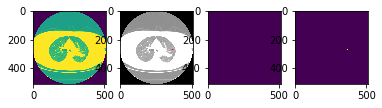

In [171]:
size = pic.shape
three_c = np.zeros(shape=[size[0], size[1], 3])
for k in range(3):
    three_c[...,k] = pic
    
# set red chanel to 1 whenever in nodules and set all other channels to 0
for x in range(size[0]):
    for y in range(size[1]):
        if nodules[x,y]==1:
            three_c[x,y,0] = 1
            three_c[x,y,1] = 0
            three_c[x,y,2] = 0
            
three_c_m = np.zeros(shape=[size[0], size[1], 3])
for k in range(3):
    three_c_m[...,k] = pic

   

    
plt.figure()
plt.subplot(141)
plt.imshow(pic)
plt.subplot(142)
plt.imshow(three_c)
plt.subplot(143)
plt.imshow(annotations)
plt.subplot(144)
plt.imshow(nodules)
plt.show()

In [2]:
from DataProcessing import LUNA
from DataProcessing import LUNA
%matplotlib inline

import pydicom as dc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import pandas as pd
import xml
from xml.etree import ElementTree
from shapely.geometry import Polygon
from shapely.geometry import Point
from random import randint
import util as ut

luna = LUNA()


Training Data found: 1595
Evaluation Data found: 1595
XML Training Data found: 18
XML Evaluation Data found: 18


In [11]:
pic_cut, nod_cut, pic_rand, nod_rand = luna.load_data()

1
2
3
4
5
6
7
8
1001
(320, 326, 139, 145)


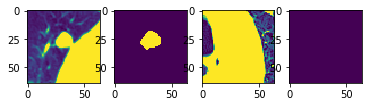

In [8]:
plt.figure()
plt.subplot(141)
plt.imshow(pics[0,...,0])
plt.subplot(142)
plt.imshow(annos[0,...,0])
plt.subplot(143)
plt.imshow(pics[61,...,0])
plt.subplot(144)
plt.imshow(annos[61,...,0])
plt.show()


In [2]:
# method to generate training data given the current model type
def generate_segmentation_data(batch_size, training_data = True):
    pics = np.zeros(shape=[batch_size*2, 64,64, 1])
    annos = np.zeros(shape=[batch_size*2, 64, 64, 1])
    for k in range(batch_size):
        pic, vertices, nodules = luna.load_data(training_data= training_data)
        pic_cut, nod_cut, pic_rand, nod_rand = luna.cut_data(pic, nodules, vertices)
        
        pics[k, ..., 0] = pic_cut
        annos[k,... , 0] = nod_cut
        
        pics[k+batch_size,...,0] = pic_rand
        annos[k+ batch_size,...,0] = nod_rand
    return pics, annos
        
pics, annos = generate_segmentation_data(batch_size=32)

1
2
3
1001


(211, 227, 212, 229)
1
2
3
4
5
6
7


8
1001


(266, 274, 363, 374)
1001


(215, 226, 217, 228)
1001


(354, 386, 299, 330)
1
2
3


1001


(281, 309, 178, 208)
1
2
3
1001


(285, 293, 118, 127)
1
2
1001


(320, 327, 139, 144)
1001


(351, 386, 302, 332)
1001


(270, 294, 180, 207)
1
1001


(348, 386, 299, 335)
1
1001


(255, 268, 287, 304)
1001


(354, 386, 299, 330)
1
2
1001


(319, 324, 140, 144)
1
2
3
4
1001


(346, 384, 299, 334)
1
2
3
4
5
6
1001


(335, 366, 352, 382)
1
2
3
4
1001


(193, 203, 301, 311)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1001


(195, 202, 302, 310)
1
2
1001


(335, 366, 352, 382)
1
2


1001


(279, 314, 179, 214)
1
2
3
4
5
6
1001


(279, 312, 179, 213)
1
2
3
4
5
6
7
1001


(394, 401, 123, 131)
1
2
3
4
5
6
7
8
9
10
11
12
13
14


1001


(280, 288, 188, 209)
1001


(265, 275, 364, 373)
1
2
3
4
5
6
1001


(280, 312, 178, 211)
1
1001


(285, 293, 118, 127)
1
2
3
4
1001


(338, 363, 360, 381)
1
2
3


1001


(279, 314, 178, 215)
1
2
1001


(351, 361, 363, 378)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
1001


(273, 290, 184, 210)
1
2
3
1001


(276, 300, 179, 211)
1
2
3
4
1001


(373, 381, 402, 410)
1
2
3
4
1001


(344, 374, 328, 364)


In [1]:
def mean_var(list):
    mean  = 0
    n = float(len(list))

    for j in list:
        mean += j/n
        
    var = 0
    for j in list:
        var += ((j - mean)**2 )/n
        
    return mean, var


In [3]:
list = [1,2,3]
mean_var(list)

(2.0, 0.6666666666666666)

In [ ]:
for k in range(1,5):
    print(k)